In [3]:
%matplotlib notebook
import matplotlib as mpl
import itertools
import PyVal
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import ipyparallel as ipp
import seaborn as sns
from tqdm import tqdm_notebook
from functools import reduce

In [4]:
sns.set_style("whitegrid")

In [5]:
#@ipp.require('PyVal', 'numpy')
indices = ['T', 'r', 'N', 'row sum', 'col sum', 'default scale', 'conn']
col_names = ['M', 'Assets', 'RS', 'Delta', 'Solvent']
tmp_cols = ['N_MC', 'N_nets', 'p']

def run_sim(N, row_val, col_val, p, T, r, default_scale):
    import numpy as np
    N_MC = 600
    N_nets = 1200
    nw = PyVal.BS_Network()
    MList = []
    rsList= []
    assetList= []
    deltaList = []
    solventList = []
    MVarList = []
    rsVarList= []
    assetVarList= []
    deltaVarList = []
    solventVarList = []
    nSamplesList = []
    ioDistList = []
    ioDistVarList = []
    #vOutList = []
    print("Runing N=" +str(N)+ ", row sum="+str(row_val)+"col sum="+str(col_val)+", p="+str(p))
    nw.run(N, p, row_val, col_val, 2, T, r, N_MC,  N_nets, default_scale)
    k_list = nw.k_vals()[0]
    res = []
    for k in k_list:
        res.append({'N_MC': N_MC, 'N_nets': N_nets ,'N': N, 'Number Of Samples': nw.get_N_samples(k)[0], 'default scale': default_scale,\
               'conn': k, 'row sum': row_val, 'col sum': col_val, 'T':T, 'r': r ,'p': p, \
               'M': nw.get_M(k), 'M var': nw.get_M_var(k),\
               'Assets': np.array(nw.get_assets(k))[0], 'Assets var': np.array(nw.get_assets_var(k))[0],\
               'RS': np.array(nw.get_rs(k))[0],  'RS var': np.array(nw.get_rs_var(k))[0],\
               'Delta': nw.get_delta_jacobians(k),  'Delta var': nw.get_delta_jacobians_var(k),\
               'Vega': np.array(nw.get_vega(k)),  'Vega var': np.array(nw.get_vega_var(k)),\
               'Theta': np.array(nw.get_theta(k)),  'Theta var': np.array(nw.get_theta_var(k)),\
               'Rho': np.array(nw.get_rho(k)),  'Rho var': np.array(nw.get_rho_var(k)),\
               'Solvent': np.array(nw.get_solvent(k)), 'Solvent var': np.array(nw.get_solvent_var(k))})
    return res

def combine_2_results(dict1, dict2):
    import copy
    res = copy.deepcopy(dict1)
    for k in tmp_cols:
        if k in res:
            res.pop(k)
    index_ok = True
    for ind in indices:
        if dict1[ind] != dict2[ind]:
            index_ok = False
    if index_ok:
        res['Number Of Samples'] = dict1['Number Of Samples'] + dict2['Number Of Samples']
        n1 = dict1['Number Of Samples'][1]
        n2 = dict2['Number Of Samples'][1]
        n_tot = n1 + n2
        for el in col_names:
            elv = el + ' var'
            res[el] = (n1*dict1[el] + n2*dict2[el])/n_tot
            res[elv] = (n1*(dict1[elv] + dict1[el]*dict1[el]) + n2*(dict2[elv] + dict2[el]*dict2[el]))/n_tot - res[el]*res[el]
        return [res]
    else:
        return [dict1, dict2]

    
def results_to_df(results):
    import copy
    candidates = {}
    df_list = []
    for r_list in results:
        for res in r_list:
            key = tuple([res[ind] for ind in indices])
            if key in candidates:
                candidates[key].append(res)
            else:
                candidates[key] = [res]
    for key, value in candidates.items():
        res_in = copy.deepcopy(value)
        while len(res_in) > 1:
            el1 = res_in.pop()
            el2 = res_in.pop()
            res_in = res_in + combine_2_results(el1, el2)
        candidates[key] = res_in[0]
        df_list.append(res_in[0])
    #res.set_index(indices, inplace=True)
    return pd.DataFrame(df_list)
        
            
    
def flatten_input(cell):
    if type(cell) is list:
        return cell[0]
    else:
        return cell

def pList(N, pts):
    import numpy as np
    #    return np.union1d(np.union1d(np.linspace(0.0, 10.0/N, pts), np.linspace(0.6/N,1.4/N,pts)), np.linspace((np.log(N)-np.log(N)/7.)/N,(np.log(N)+np.log(N)/7.)/N,pts))
    return np.union1d(np.linspace(0.0, 2.0/N, pts), np.union1d(np.linspace(0.0, 15.0/N, 2*pts), np.linspace(0.7/N, (np.log(N)+np.log(N)/7.)/N, 2*pts)))

def pFixedList(N, pts):
    import numpy as np
    return np.linspace(0.0, (pts-1)/N, pts)

In [6]:
Nlist = [80]
NPoints = 1
default_scales = [1.0]
row_vals = [0.99]
inp = (100, 0.9, 0.9, 1.0, 1.0, 0.0, 1.0)
p_1_r_0 = run_sim(*inp)

Runing N=100, row sum=0.9col sum=0.9, p=1.0


In [7]:
p_1_r_0 = results_to_df([p_1_r_0])

In [8]:
p_1_r_0.to_pickle("./single_p1r0t1v09.pkl")

In [1]:
p_0_r_0.to_pickle("./single_p0r0t1v09.pkl")
p_0_r_1.to_pickle("./single_p0r1t1v09.pkl")
p_1_r_1.to_pickle("./single_p1r1t1v09.pkl")
p_1_r_0.to_pickle("./single_p1r0t1v09.pkl")

NameError: name 'p_0_r_0' is not defined

<IPython.core.display.Javascript object>


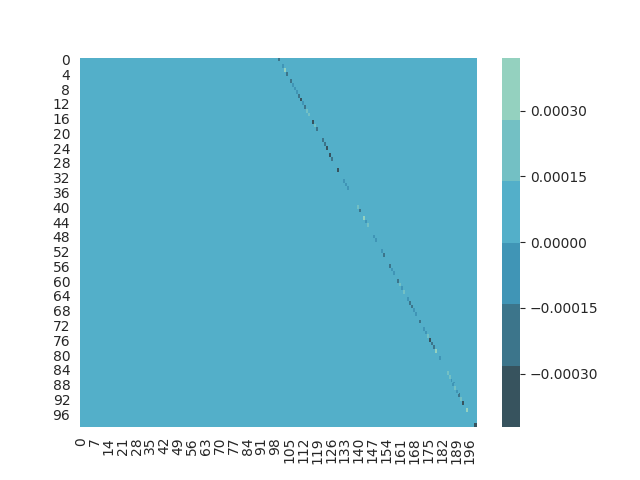

In [36]:
cmap = sns.color_palette("GnBu_d")
from matplotlib import colors
bounds=[0,5,10]
#norm = colors.BoundaryNorm(bounds, cmap.N)
sns.heatmap(a_df['Vega'].values[0], cmap=cmap)

In [27]:
a1['Vega'].values

array([array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.18784684e-04,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  5.91279785e-05,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -3.25506523e-04]])],
      dtype=object)

In [ ]:
np.exp()